# **SARSA on Grid World Environment**

I have developed a **4x4 grid world environment** where agent can choose from one of the four actions defined below to reach the target in as less steps as it can by increasing the cumulative reward along the way.

**Actions:** {down, up, right, left}

**States:** {s1, s2, s3, s4, s5....s16} -> 4x4 grid

**Rewards:** {-4, -3, 0, 2, 5, 20}

**Main Goals:** 
1. To run a random agent in the environment for 15 timesteps or episodes and display the rewards acquired in the environments. 

2. Apply SARSA to find the **optimal path** (i.e. **path with lesser steps and more cumulative reward**) and tune hyperparameters to see how they impact the agent learning process

# **Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym #library for reinforcement problems
from gym import spaces
import time

# **Grid world Environment**

In [2]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    
    def __init__(self):
        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.done = False
        
    def reset(self):
        
        self.done = False
        self.state = np.zeros((4,4))
        self.agent_pos = [0, 0]
        self.goal_pos = [3, 3]       
        self.danger1_pos = [2,0] #first danger position (-3)
        self.danger2_pos = [1,2] #second danger position (-4)
        self.gold1_pos = [1,0] #First positive reward position (+2)
        self.gold2_pos = [3,1] #Second positive reward position (+5)

        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.8
        self.state[tuple(self.gold1_pos)] = 0.7
        self.state[tuple(self.gold2_pos)] = 0.7
        self.state[tuple(self.danger1_pos)] = 0.3
        self.state[tuple(self.danger2_pos)] = 0.3
        observation = self.state.flatten()
        return observation
    
    def step(self, action):

        self.state = np.random.choice(self.observation_space.n)
        if action == 0:
          self.agent_pos[0] += 1
        if action == 1:
          self.agent_pos[0] -= 1
        if action == 2:
          self.agent_pos[1] += 1
        if action == 3:
          self.agent_pos[1] -= 1
          
        self.agent_pos = np.clip(self.agent_pos, 0, 3)
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.8
        self.state[tuple(self.gold1_pos)] = 0.7
        self.state[tuple(self.gold2_pos)] = 0.7
        self.state[tuple(self.danger1_pos)] = 0.3
        self.state[tuple(self.danger2_pos)] = 0.3
        observation = self.state.flatten()
        
        reward = 0
        if (self.agent_pos == self.goal_pos).all():
          reward = 20 #Target position: Given max reward if it reaches target
          self.done = True

        elif (self.agent_pos == self.danger1_pos).all():
            reward = -3 #A negative reward -3 if it enters 1st danger position

        elif (self.agent_pos == self.danger2_pos).all():
            reward = -4 #A negative reward of -4 if it enters 2nd danger position

        elif (self.agent_pos == self.gold1_pos).all():
            reward = 2 #A reward of +2 at [1,1]

        elif (self.agent_pos == self.gold2_pos).all():
            reward = 5 #A reward of +5 at [2,2]
        
        return self.agent_pos, reward, self.done
        
    def render(self):
        plt.imshow(self.state)

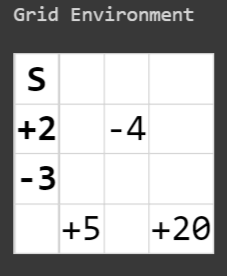

# **SARSA Algorithm**

In [3]:
#SARSA
def sarsa(discount_factor = 0.95, timesteps = 15, episodes = 1000, evaluation_results = False):
  env = GridEnvironment()
  obs = env.reset()#resets the environment to its initial configuration

  #Intialize parameters
  learning_rate = 0.15 #alpha
  discount_factor = discount_factor #how much weightage to put on future rewards
  det_epsilon = 0.99 # For all states in deterministic environment p(s', r/s, a) = {0, 1}: Either action taken or No action taken


  #Intial state
  current_state = 0 #s1
  action_val = [0,1,2,3]

  #Q table representing 16 rows: one for each state (i.e., 0,1,2,...15) -> (i.e., s1, s2, s3,....s16) and 4 columns: one for each action (i.e., 0,1,2,3) -> (down,up,right,left)
  # (0-15, 0-3) remember the dimension is one less
  q_table = np.zeros((16,4))

  #mapping next_state co-ordinates to q_table co-ordinates
  states = {(0,0): 0, (0,1): 1, (0,2): 2, (0,3): 3,
                (1,0): 4, (1,1): 5, (1,2): 6, (1,3): 7,
                (2,0): 8, (2,1): 9, (2,2): 10, (2,3): 11,
                (3,0): 12, (3,1): 13, (3,2): 14, (3,3): 15} #16 states

  #Empty lists to store values
  optimal = []
  reward_values = []
  total_timesteps = []
  epsilon_values = []
  eva_rewards = []


  done = False #signifies if agent reached terminal or not 
  total_episodes = episodes
  eva_episodes = 10
  avg_timesteps = 0
  epsilon = 1 #multiply by 0.995 for each episode(#after 30 iterations# or terminal state reached)
  decay_factor = (0.01/1)**(1/total_episodes)
  target = np.array([3,3])

  #For evaluation results
  if evaluation_results: 
     total_episodes += eva_episodes 
     print("Evaluation Results")

  for episode in range(1, total_episodes+1):
    
    obs = env.reset() #resets the environment
    current_state = 0 
    total_rewards = 0
    timestep = 0


    #e - greedy algorithm to choose s and a
    rand_num = np.random.random()
    if epsilon > rand_num:
      action = np.random.choice(action_val)
    else:
      action = np.argmax(q_table[current_state]) #action in current state s with max_q value

    while timestep < timesteps: #(i.e., considering untill the terminal is reached or 15 timesteps are completed)
    
      rand_num = np.random.random()
      if det_epsilon > rand_num: #Choosing an action in deterministic environment
          
          next_state_pos, reward, done = env.step(action)
          next_state = states[tuple(next_state_pos)]

          if reward == 20:
            reward += 100

          if np.linalg.norm(target - np.array(next_state_pos)) <= 1:
            reward = reward + 5  #before +1, 5 is good

          #e - greedy algorithm to choose next_action for next_state
          rand_num = np.random.random()
          if epsilon > rand_num:
            next_action = np.random.choice(action_val)
          else:
            next_action = np.argmax(q_table[next_state]) #action in next state s' with max_q value
          
          #q-value update function for SARSA
          q_table[current_state][action] = q_table[current_state][action] + learning_rate*(reward + discount_factor*q_table[next_state][next_action] - q_table[current_state][action])

          if episode == total_episodes:
            optimal.append(current_state+1)

          total_rewards += reward #Captured all the rewards in each episode
          timestep += 1 #Number of timesteps in each episode

          current_state = next_state #next_state is assigned to current_state
          action = next_action
          
          if done == True: #If terminal or target state reached then stop the episode
            done = False
            break        
          
    
    #Results after each episode
    avg_timesteps += timestep #Capturing all timesteps for all 100 episodes
    total_timesteps.append(avg_timesteps)

    reward_values.append(total_rewards) #Append rewards in every episode
    epsilon_values.append(epsilon) #Append epsilon values in every episode


    if epsilon > 0.01: #keeping epsilon in [0.01 - 1] range as if it falls below 0.01 it will exploit more: choosing best actions. We want our agent to explore a bit: choosing random actions
        epsilon = epsilon*decay_factor
    else:
        epsilon = 0.01


    if (episode % 100) == 0 and evaluation_results == False: #printing results for every 100 episodes
      print("Episode: {}, Rewards: {}, Average timesteps taken: {}, epsilon: {}".format(episode, total_rewards, avg_timesteps//100, epsilon))
      avg_timesteps = 0

    #evaluation results
    if evaluation_results:
      if episode > total_episodes - eva_episodes:
         eva_rewards.append(reward)

    #printing the optimal path in last episode
    if episode == total_episodes:
          print("Optimal Path: ")
          for i in optimal:
            print(i,"->", end = " ")
          print(next_state+1)

  #Final Q - Table
  print("Q Table: \n", q_table)

  #Plotting the results
  #x, y co-ordinates
  x = [episode for episode in range(total_episodes)]
  yr = reward_values
  ye = epsilon_values

  yr_eva = eva_rewards
  x_eva = [episode for episode in range(eva_episodes)]
 

  if evaluation_results:
      #episodes vs rewards
      plt.plot(x_eva,yr_eva)
      plt.title("Rewards per episode")
      plt.xlabel('Episodes')
      plt.ylabel('Rewards')

  else:
      #episodes vs epsilon
      #Plots showing episodes vs epsilon, episodes vs rewards
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
      ax1.plot(x, ye)
      ax1.set_title("Epsilon decay")

      #episodes vs rewards
      ax2.plot(x,yr)
      ax2.set_title("Rewards per episode")


Episode: 100, Rewards: 143, Average timesteps taken: 14, epsilon: 0.6309573444801949
Episode: 200, Rewards: 137, Average timesteps taken: 11, epsilon: 0.39810717055349926
Episode: 300, Rewards: 137, Average timesteps taken: 8, epsilon: 0.2511886431509601
Episode: 400, Rewards: 142, Average timesteps taken: 7, epsilon: 0.15848931924611304
Episode: 500, Rewards: 137, Average timesteps taken: 6, epsilon: 0.1000000000000013
Episode: 600, Rewards: 137, Average timesteps taken: 6, epsilon: 0.06309573444802027
Episode: 700, Rewards: 137, Average timesteps taken: 6, epsilon: 0.039810717055350435
Episode: 800, Rewards: 137, Average timesteps taken: 6, epsilon: 0.025118864315096318
Episode: 900, Rewards: 137, Average timesteps taken: 6, epsilon: 0.01584893192461151
Episode: 1000, Rewards: 137, Average timesteps taken: 6, epsilon: 0.010000000000000266
Optimal Path: 
1 -> 5 -> 6 -> 10 -> 14 -> 15 -> 16
Q Table: 
 [[ 1.06447925e+02  8.66406150e+01  7.29137735e+01  8.79412612e+01]
 [ 1.02328318e+02 

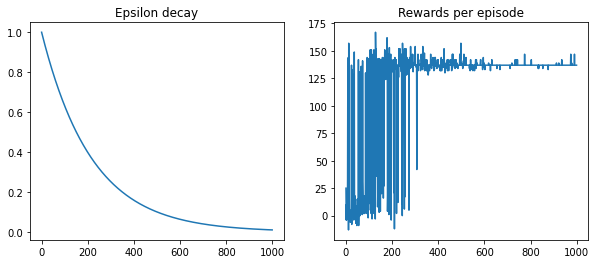

In [4]:
sarsa(discount_factor = 0.95, timesteps = 15, episodes = 1000)

***From above plots, we can infer that the reward is increasing while epsilon is decreasing smoothly over the episodes, which indicates the agent is learning. The agent can choose the optimal path, the path with more rewards and reaching target in fewer timesteps.***

Evaluation Results
Optimal Path: 
1 -> 5 -> 9 -> 10 -> 14 -> 15 -> 16
Q Table: 
 [[103.91611627  85.52684518  81.3219711   89.42117863]
 [ 97.1641999   17.1326409    8.73379858  40.82513978]
 [  1.53788773   1.90356162   1.03784295  39.533126  ]
 [  6.06502426   1.35044268   0.74086324   3.51824407]
 [107.48441425  76.46359009  94.28415123  90.17032342]
 [112.95184434  43.78035067  65.19307185  64.23064807]
 [ 98.49624077   5.33083312  27.95943179   3.82344444]
 [ 69.02111965   0.81616545   2.54042561   7.52856222]
 [ 93.43286188  84.12034251 116.39763355  81.45471194]
 [122.55661358  89.04370407 101.82377255  92.97180521]
 [123.37391775  40.57723561  43.08537879  47.84172282]
 [112.15379131   5.25393812   4.02178273  22.66530239]
 [ 20.82394564  12.74792177 119.26922186  36.34229153]
 [112.84827563 108.28748378 123.7498833  106.20231234]
 [120.82245354  99.88581844 125.         119.21025666]
 [  0.           0.           0.           0.        ]]


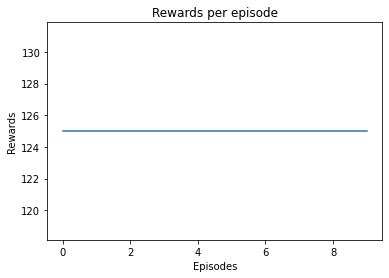

In [5]:
sarsa(evaluation_results=True) #During evaluation the agent doesn't learn it just picks the best next action (i.e. greedy action)

***During evaluation the agent can choose the optimal path (i.e. there are more than 1 optimal path), the path with more rewards and reaching target in fewer timesteps. From above plot it is evident the agent has learnt the optimal policy and can pick the best path towards the goal, with the maximum cumulative reward.***

# **Hyperparamter tuning**

### **1. Maximum timesteps: 10**

Episode: 100, Rewards: 10, Average timesteps taken: 9, epsilon: 0.6309573444801949
Episode: 200, Rewards: 5, Average timesteps taken: 9, epsilon: 0.39810717055349926
Episode: 300, Rewards: 137, Average timesteps taken: 8, epsilon: 0.2511886431509601
Episode: 400, Rewards: 137, Average timesteps taken: 7, epsilon: 0.15848931924611304
Episode: 500, Rewards: 137, Average timesteps taken: 6, epsilon: 0.1000000000000013
Episode: 600, Rewards: 132, Average timesteps taken: 6, epsilon: 0.06309573444802027
Episode: 700, Rewards: 137, Average timesteps taken: 6, epsilon: 0.039810717055350435
Episode: 800, Rewards: 137, Average timesteps taken: 6, epsilon: 0.025118864315096318
Episode: 900, Rewards: 137, Average timesteps taken: 6, epsilon: 0.01584893192461151
Episode: 1000, Rewards: 137, Average timesteps taken: 6, epsilon: 0.010000000000000266
Optimal Path: 
1 -> 5 -> 6 -> 10 -> 14 -> 15 -> 16
Q Table: 
 [[ 1.04066777e+02  6.87656322e+01  6.17585564e+01  7.45682114e+01]
 [ 4.08582490e+00  1.53

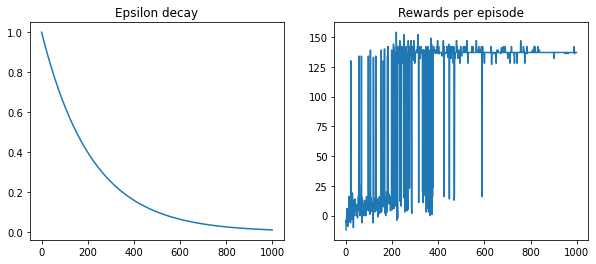

In [6]:
sarsa(timesteps = 10)

### **2. Maximum timesteps: 20**

Episode: 100, Rewards: 2, Average timesteps taken: 18, epsilon: 0.6309573444801949
Episode: 200, Rewards: 133, Average timesteps taken: 11, epsilon: 0.39810717055349926
Episode: 300, Rewards: 139, Average timesteps taken: 8, epsilon: 0.2511886431509601
Episode: 400, Rewards: 147, Average timesteps taken: 7, epsilon: 0.15848931924611304
Episode: 500, Rewards: 134, Average timesteps taken: 7, epsilon: 0.1000000000000013
Episode: 600, Rewards: 144, Average timesteps taken: 6, epsilon: 0.06309573444802027
Episode: 700, Rewards: 134, Average timesteps taken: 6, epsilon: 0.039810717055350435
Episode: 800, Rewards: 134, Average timesteps taken: 6, epsilon: 0.025118864315096318
Episode: 900, Rewards: 134, Average timesteps taken: 6, epsilon: 0.01584893192461151
Episode: 1000, Rewards: 134, Average timesteps taken: 6, epsilon: 0.010000000000000266
Optimal Path: 
1 -> 5 -> 9 -> 13 -> 14 -> 15 -> 16
Q Table: 
 [[ 1.02932166e+02  8.67774142e+01  6.50221834e+01  8.59970777e+01]
 [ 4.01328241e+01  1

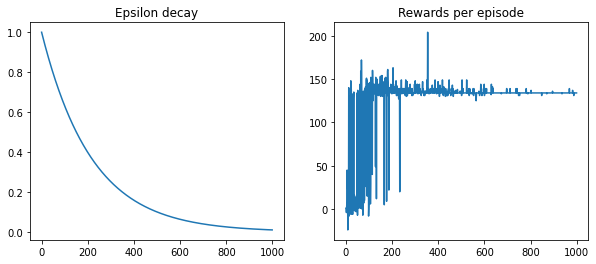

In [7]:
sarsa(timesteps = 20)

### **3. Maximum timesteps: 25**

Episode: 100, Rewards: 135, Average timesteps taken: 19, epsilon: 0.6309573444801949
Episode: 200, Rewards: 132, Average timesteps taken: 11, epsilon: 0.39810717055349926
Episode: 300, Rewards: 132, Average timesteps taken: 8, epsilon: 0.2511886431509601
Episode: 400, Rewards: 132, Average timesteps taken: 7, epsilon: 0.15848931924611304
Episode: 500, Rewards: 132, Average timesteps taken: 6, epsilon: 0.1000000000000013
Episode: 600, Rewards: 132, Average timesteps taken: 6, epsilon: 0.06309573444802027
Episode: 700, Rewards: 137, Average timesteps taken: 6, epsilon: 0.039810717055350435
Episode: 800, Rewards: 137, Average timesteps taken: 6, epsilon: 0.025118864315096318
Episode: 900, Rewards: 137, Average timesteps taken: 6, epsilon: 0.01584893192461151
Episode: 1000, Rewards: 137, Average timesteps taken: 6, epsilon: 0.010000000000000266
Optimal Path: 
1 -> 5 -> 6 -> 10 -> 14 -> 15 -> 16
Q Table: 
 [[106.52357689  91.5419095   67.07855235  88.67457129]
 [104.73571925  36.20418154  2

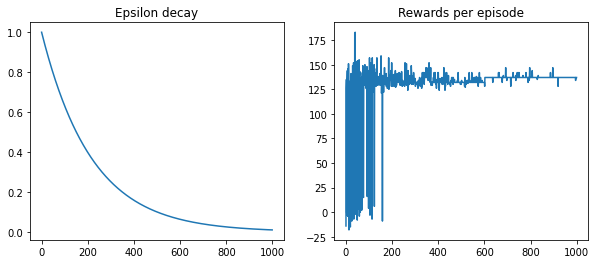

In [8]:
sarsa(timesteps = 25)

**When timesteps value is set to 10 there is lot of reward fluctuation at first, but the agent can learn the policy over the episodes. When timesteps are increased the agent can explore more in every episode and able to learn policy sooner, which is evident from 3rd plot, less variation in reward values.** 

### **1. Episodes: 500**

Episode: 100, Rewards: 147, Average timesteps taken: 13, epsilon: 0.39810717055349837
Episode: 200, Rewards: 139, Average timesteps taken: 8, epsilon: 0.15848931924611231
Episode: 300, Rewards: 137, Average timesteps taken: 6, epsilon: 0.06309573444801994
Episode: 400, Rewards: 137, Average timesteps taken: 6, epsilon: 0.0251188643150961
Episode: 500, Rewards: 137, Average timesteps taken: 6, epsilon: 0.010000000000000146
Optimal Path: 
1 -> 5 -> 6 -> 10 -> 14 -> 15 -> 16
Q Table: 
 [[ 1.04987120e+02  5.62280821e+01  2.24942443e+01  5.70590469e+01]
 [ 1.19893599e+01  1.36758538e+00  5.58613486e-01  6.04421056e+01]
 [-2.21459478e+00  1.26388169e-03  0.00000000e+00  8.44995176e+00]
 [-2.30850000e-01  0.00000000e+00 -2.23851772e-02 -7.26750000e-02]
 [ 6.03087217e+01  5.81714318e+01  1.09887903e+02  4.34844284e+01]
 [ 1.15656508e+02  1.77928860e+01  2.13688336e+01  5.24760613e+01]
 [ 1.44456945e+00 -3.42610325e-01  1.97718750e-01  6.70278529e+01]
 [ 1.16960223e+01 -1.73618437e-03  1.068750

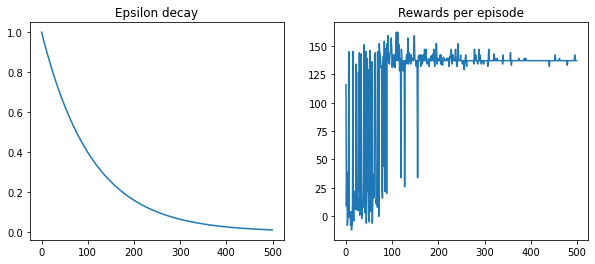

In [9]:
sarsa(episodes = 500)

### **2. Episodes: 3000**

Episode: 100, Rewards: 14, Average timesteps taken: 14, epsilon: 0.8576958985908986
Episode: 200, Rewards: 126, Average timesteps taken: 13, epsilon: 0.7356422544596488
Episode: 300, Rewards: 131, Average timesteps taken: 11, epsilon: 0.6309573444802022
Episode: 400, Rewards: 139, Average timesteps taken: 11, epsilon: 0.541169526546474
Episode: 500, Rewards: 131, Average timesteps taken: 10, epsilon: 0.46415888336128897
Episode: 600, Rewards: 133, Average timesteps taken: 9, epsilon: 0.39810717055350886
Episode: 700, Rewards: 144, Average timesteps taken: 9, epsilon: 0.3414548873833718
Episode: 800, Rewards: 148, Average timesteps taken: 8, epsilon: 0.2928644564625351
Episode: 900, Rewards: 131, Average timesteps taken: 7, epsilon: 0.25118864315096906
Episode: 1000, Rewards: 139, Average timesteps taken: 7, epsilon: 0.21544346900319894
Episode: 1100, Rewards: 131, Average timesteps taken: 7, epsilon: 0.18478497974223917
Episode: 1200, Rewards: 134, Average timesteps taken: 7, epsilon: 

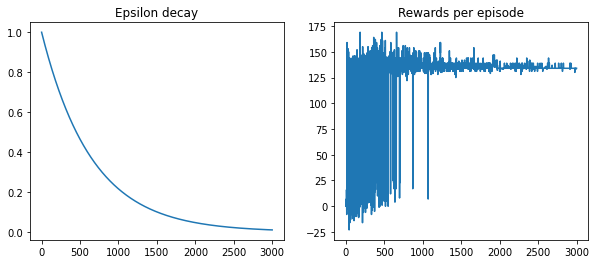

In [10]:
sarsa(episodes = 3000)

### **3. Episodes: 5000**

Episode: 100, Rewards: 24, Average timesteps taken: 14, epsilon: 0.9120108393559109
Episode: 200, Rewards: 6, Average timesteps taken: 14, epsilon: 0.8317637711026723
Episode: 300, Rewards: 23, Average timesteps taken: 13, epsilon: 0.7585775750291857
Episode: 400, Rewards: 128, Average timesteps taken: 12, epsilon: 0.6918309709189385
Episode: 500, Rewards: 120, Average timesteps taken: 11, epsilon: 0.630957344480195
Episode: 600, Rewards: 138, Average timesteps taken: 11, epsilon: 0.5754399373371587
Episode: 700, Rewards: 141, Average timesteps taken: 11, epsilon: 0.5248074602497744
Episode: 800, Rewards: 136, Average timesteps taken: 10, epsilon: 0.4786300923226403
Episode: 900, Rewards: 142, Average timesteps taken: 10, epsilon: 0.4365158322401678
Episode: 1000, Rewards: 135, Average timesteps taken: 9, epsilon: 0.39810717055349937
Episode: 1100, Rewards: 153, Average timesteps taken: 8, epsilon: 0.3630780547701035
Episode: 1200, Rewards: 134, Average timesteps taken: 8, epsilon: 0.3

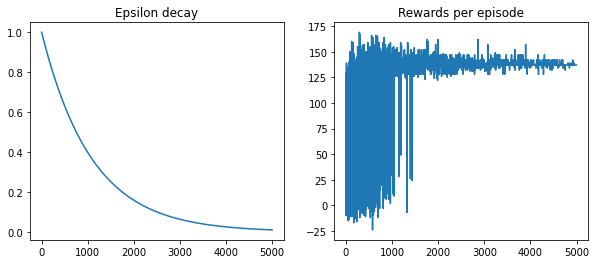

In [11]:
sarsa(episodes = 5000)

***So, the agent hasn’t learnt the optimal policy when I ran agent for fewer episodes (i.e. sometimes it learned as agent figured a way to reach target but it is not true all the time), the agent isn’t able to explore more to figure out the optimal path.***

### **Observations:**

* I have decreased epsilon smoothly over the episodes by using **decay_factor = (0.01/1)^(1/total episodes)**. So, with more episodes the agent will explore more in more episodes at first (i.e., evident from 2nd and 3rd plot with 3000, 5000 episodes) because epsilon is large and starts to converge in latter episodes as epsilon is less, the agent makes more of greedy actions. The agent has learnt the optimal path in 2nd and 3rd cases.

* By experimenting with different hyperparameters, for our model I have concluded a **discount factor of 0.95 and timesteps of 15 and episodes = 1000** provided best results.